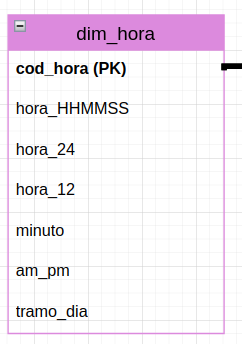

# Importar librerías

In [ ]:
from datetime import datetime # Tiempo actual
import pandas as pd # Manipulacion de datos
import sqlalchemy as sa # Conexon a la BD
import utils.conn_tools as ct  # Util para la configuracion de la BD
import numpy as np # Para operaciones matematicas

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

print(config_src)
print(config_etl)

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

## Extract

## Transform: Creación de la dimensión

In [ ]:
# Creacion de rango de horas con saltos de un minuto
hora_range = pd.date_range(start="00:00:00", end="23:59:00", freq="1T")

dim_hora = pd.DataFrame(
    {
        "hour_HHMMSS": hora_range.strftime("%H:%M:%S"),
        "hour_24": hora_range.hour,
        "hour_12": np.where(
            hora_range.hour % 12 == 0, 12, hora_range.hour % 12
        ),
        "minute": hora_range.minute,
        "am_pm": [
            "AM" if h.hour < 12 else "PM" for h in hora_range
        ],
        "day_section": pd.cut(
            hora_range.hour,
            bins=[-1, 5, 11, 17, 24],
            labels=["Madrugada", "Mañana", "Tarde", "Noche"],
            right=True,
        ),
    }
)


print(dim_hora.iloc[358:362])
print(dim_hora.iloc[718:722])
print(dim_hora.iloc[1078:1082])

print(f"x{dim_hora.shape[0]} registros")

In [ ]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

dim_hora_table = sa.Table(
    "dim_hora",
    metadata,
    # Primary key
    sa.Column("key_hora", sa.Integer, primary_key=True, autoincrement=True),
    # Dimension properties
    sa.Column("hour_HHMMSS", sa.Time, nullable=False),
    sa.Column("hour_24", sa.Integer, nullable=False),
    sa.Column("hour_12", sa.Integer, nullable=False),
    sa.Column("minute", sa.Integer, nullable=False),
    sa.Column("am_pm", sa.String(length=2), nullable=False),
    sa.Column("day_section", sa.String(length=10), nullable=False),
)

metadata.create_all(engine_etl)

## Load

In [ ]:
dim_hora.to_sql(
    name="dim_hora",
    con=engine_etl,
    if_exists="append",  # Create table if not exists, else append
    index=False,  # Do not create index because we already have one PK
)